### Definición experimentación 1ª Iteración

**En esta iteración se utilizará tal cual el entorno de OpenAI gymAnytrading, sin realizarle ninguna modificación**.

**Series a predecir**: todos los pares de divisas

**Longitud entrenamiento**: 2 años.

**Longitud test**: 6 meses.

**window_size**: Fijo o variable. Creo que fijo a 50 días es lo que renta. Fijo a 50 días.

**Medición del mejor modelo**: el que en el conjunto de test saque el mejor sharpe ratio.

**Entre qué se elige**: distintos modelos y distintas políticas para cada modelo. Combinamos estos y sacamos la mejor combinación para cada par de divisas.

In [111]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import A2C
from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

In [112]:
AUDUSD = pd.read_csv('../../Datasets/AUDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
EURUSD = pd.read_csv('../../Datasets/EURUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
GBPUSD = pd.read_csv('../../Datasets/GBPUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
NZDUSD = pd.read_csv('../../Datasets/NZDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCAD = pd.read_csv('../../Datasets/USDCAD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCHF = pd.read_csv('../../Datasets/USDCHF_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDJPY = pd.read_csv('../../Datasets/USDJPY_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')

In [113]:
# 1. Limpiamos el dataset ya que las fechas como vienen están mal
# 2. Asignamos el conjunto de entrenamiento y test de cada par de divisas. 
# El train va desde Junio 2019 a Junio 2021 y el test de Junio 2021 a Diciembre 2021

df_pair = {}
df_pair['AUDUSD'] = AUDUSD
df_pair['EURUSD'] = EURUSD
df_pair['GBPUSD'] = GBPUSD
df_pair['NZDUSD'] = NZDUSD
df_pair['USDCAD'] = USDCAD
df_pair['USDCHF'] = USDCHF
df_pair['USDJPY'] = USDJPY
df_train = {}
df_test = {}
names = list(df_pair.keys())
for i in range(len(df_pair)):
    df = df_pair[names[i]]
    df = df.drop(df[df.Volume == 0].index)
    df = df.rename(columns={'Gmt time': 'Date'})
    #AUDUSD['Date'] =  pd.to_times(AUDUSD['Date'])
    #AUDUSD.set_index('Date', inplace=True)

    df['Day'] = df['Date'].astype(str).str[0:2]
    df['Month'] = df['Date'].astype(str).str[3:5]
    df['Year'] = df['Date'].astype(str).str[6:10]
    df['Hour'] = df['Date'].astype(str).str[11:13]
    df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year', 'Hour']])
    df.set_index('Date', inplace=True)
    df = df[["Open","High","Low","Close","Volume"]]
    df_pair[names[i]] = df
    # Train
    df_train[names[i]] = df_pair[names[i]].query("20190630 < index < 20210701")
    # Test
    df_test[names[i]] = df_pair[names[i]].query("20210701 < index < 20211226")

In [136]:
window_size_1 = 50
start_index = window_size_1
end_index = len(df_train[names[0]])
frame_bound = (start_index, end_index)

#desired_total_episodes = 75
desired_total_episodes = 50
n_points = end_index - start_index
# get the number of timesteps
total_timesteps = desired_total_episodes*n_points

In [137]:
# Defining functions

In [138]:
def model_train_test(df_train,df_test, algo, policy):
    # Train
    env_maker = lambda: gym.make(
        'forex-v0',
        df = df_train,
        window_size = window_size_1,
        frame_bound = (window_size_1, len(df_train))
    )
    env = DummyVecEnv([env_maker])
    model = algo(policy, env)
    #model = algo(policy, env, verbose=1)
    model.learn(total_timesteps=total_timesteps)
    
    # Test
    env = gym.make('forex-v0', df=df_test, frame_bound=(window_size_1, len(df_test)), window_size=window_size_1)
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    start_index = window_size_1
    end_index = len(df_test)
    qs.extend_pandas()
    net_worth = pd.Series(env.history['total_profit'], index=df_test.index[start_index+1:end_index])
    returns = net_worth.pct_change().iloc[1:]
    return(returns)

### Results A2C

In [139]:
# RESULTS A2C
results = {} 
policy_A2C = ['MlpPolicy','MlpLstmPolicy','MlpLnLstmPolicy']
# Create dictionary with each pair
for i in range(len(df_train)):
    results[str(names[i])] = {}

for i in range(len(df_train)):
    for j in range(len(policy_A2C)):
        results[str(names[i])]['A2C_'+str(policy_A2C[j])] = model_train_test(df_train[names[i]],df_test[names[i]], A2C, policy_A2C[j])

info {'total_reward': 543.4999999999449, 'total_profit': 0.7821144210353159, 'position': 1}
info {'total_reward': -42.900000000000226, 'total_profit': 0.9510766810420171, 'position': 0}
info {'total_reward': -320.1999999999827, 'total_profit': 0.9510503540125653, 'position': 1}
info {'total_reward': 377.60000000001764, 'total_profit': 0.9195788467535825, 'position': 0}
info {'total_reward': 489.50000000001387, 'total_profit': 1.0059364449807546, 'position': 1}
info {'total_reward': 426.99999999998425, 'total_profit': 1.0081931170740424, 'position': 0}
info {'total_reward': -1275.3000000000136, 'total_profit': 0.8252989188182637, 'position': 0}
info {'total_reward': 705.3, 'total_profit': 1.0371254978690227, 'position': 0}
info {'total_reward': 560.7999999999856, 'total_profit': 1.0114262457369159, 'position': 0}
info {'total_reward': -443.79999999999154, 'total_profit': 0.7599204040168371, 'position': 0}
info {'total_reward': 6.000000000039217, 'total_profit': 0.7481296373703313, 'posi

In [174]:
# Para guardar los resultados
try:
    geeky_file = open('A2C_iter_1', 'wb')
    pickle.dump(results, geeky_file)
    geeky_file.close()
  
except:
    print("Something went wrong")

In [175]:
with open('A2C_iter_1', 'rb') as f:
    A2C_iter_1 = pickle.load(f)

### Results DQN

In [190]:
# RESULTS DQN
results = {} 
policy_DQN = ['MlpPolicy','LnMlpPolicy']
# Create dictionary with each pair
for i in range(len(df_train)):
    results[str(names[i])] = {}

for i in range(len(df_train)):
    for j in range(len(policy_DQN)):
        results[str(names[i])]['DQN_'+str(policy_DQN[j])] = model_train_test(df_train[names[i]],df_test[names[i]], DQN, policy_DQN[j])

info {'total_reward': 0.0, 'total_profit': 1.0413669812497401, 'position': 0}
info {'total_reward': 0.0, 'total_profit': 1.0413669812497401, 'position': 0}
info {'total_reward': 0.0, 'total_profit': 1.0477533553783311, 'position': 0}
info {'total_reward': 0.0, 'total_profit': 1.0477533553783311, 'position': 0}
info {'total_reward': 0.0, 'total_profit': 1.0327527069742417, 'position': 0}
info {'total_reward': -0.5000000000010552, 'total_profit': 0.999746815298143, 'position': 1}
info {'total_reward': 0.0, 'total_profit': 1.0321071906575872, 'position': 0}
info {'total_reward': 0.0, 'total_profit': 1.0321071906575872, 'position': 0}
info {'total_reward': -0.10000000000065512, 'total_profit': 0.9997488271850009, 'position': 1}
info {'total_reward': -0.10000000000065512, 'total_profit': 0.9997488271850009, 'position': 1}
info {'total_reward': 2.100000000000435, 'total_profit': 0.9999024051703573, 'position': 1}
info {'total_reward': 2.100000000000435, 'total_profit': 0.9999024051703573, 'p

In [191]:
# Para guardar los resultados
try:
    geeky_file = open('DQN_iter_1', 'wb')
    pickle.dump(results, geeky_file)
    geeky_file.close()
  
except:
    print("Something went wrong")

In [192]:
with open('DQN_iter_1', 'rb') as f:
    DQN_iter_1 = pickle.load(f)

In [193]:
DQN_iter_1

{'AUDUSD': {'DQN_MlpPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.000000
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00    0.000000
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00    0.041367
  Length: 2992, dtype: float64,
  'DQN_LnMlpPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    0.000000
  2021-07-05 08:00:00    0.000000
  2021-07-05 09:00:00    0.000000
                           ...   
  2021-12-24 17:00:00    0.000000
  2021-12-24 18:00:00    0.000000
  2021-12-24 19:00:00    0.000000
  2021-12-24 20:00:00    0.000000
  2021-12-24 21:00:00    0.041367
  Length: 2992, dtype: float64},
 'EURUSD': {'DQN_MlpPolicy': Date
  2021-07-05 05:00:00    0.000000
  2021-07-05 06:00:00    0.000000
  2021-07-05 07:00:00    

In [ ]:
# Hora de inicio del bucle: 13:17. Fin:  22:32

In [196]:
DQN_iter_1['GBPUSD']

{'DQN_MlpPolicy': Date
 2021-07-05 05:00:00    0.000000
 2021-07-05 06:00:00    0.000000
 2021-07-05 07:00:00    0.000000
 2021-07-05 08:00:00    0.000000
 2021-07-05 09:00:00    0.000000
                          ...   
 2021-12-24 17:00:00    0.000000
 2021-12-24 18:00:00    0.000000
 2021-12-24 19:00:00    0.000000
 2021-12-24 20:00:00    0.000000
 2021-12-24 21:00:00    0.032753
 Length: 2992, dtype: float64,
 'DQN_LnMlpPolicy': Date
 2021-07-05 05:00:00    0.0
 2021-07-05 06:00:00    0.0
 2021-07-05 07:00:00    0.0
 2021-07-05 08:00:00    0.0
 2021-07-05 09:00:00    0.0
                       ... 
 2021-12-24 17:00:00    0.0
 2021-12-24 18:00:00    0.0
 2021-12-24 19:00:00    0.0
 2021-12-24 20:00:00    0.0
 2021-12-24 21:00:00    0.0
 Length: 2992, dtype: float64}

In [198]:
DQN_iter_1['EURUSD']['DQN_LnMlpPolicy']

Date
2021-07-05 05:00:00    0.000000
2021-07-05 06:00:00    0.000000
2021-07-05 07:00:00    0.000000
2021-07-05 08:00:00    0.000000
2021-07-05 09:00:00    0.000000
                         ...   
2021-12-24 17:00:00    0.000000
2021-12-24 18:00:00    0.000000
2021-12-24 19:00:00    0.000000
2021-12-24 20:00:00    0.000000
2021-12-24 21:00:00    0.047753
Length: 2992, dtype: float64

C:\Users\Usuario\.conda\envs\TFM_RL\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Usuario\.conda\envs\TFM_RL\lib\site-packages\scipy\stats\_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Usuario\.conda\envs\TFM_RL\lib\site-packages\scipy\stats\_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             0.0%

Cumulative Return          0.0%
CAGR﹪                     0.0%

Sharpe                     nan
Smart Sharpe               nan
Sortino                    nan
Smart Sortino              nan
Sortino/√2                 nan
Smart Sortino/√2           nan
Omega                      nan

Max Drawdown               %
Longest DD Days            -
Volatility (ann.)          0.0%
Calmar                     nan
Skew                       0.0
Kurtosis                   0.0

Expected Daily %           0.0%
Expected Monthly %         0.0%
Expected Yearly %          0.0%
Kelly Criterion            nan%
Risk of Ruin               1.0%
Daily Value-at-Risk        nan%
Expected Shortfall (cVaR)  nan%

Gain/Pain Ratio            nan
Gain/Pain (1M)             nan

Payoff Ratio               nan


None

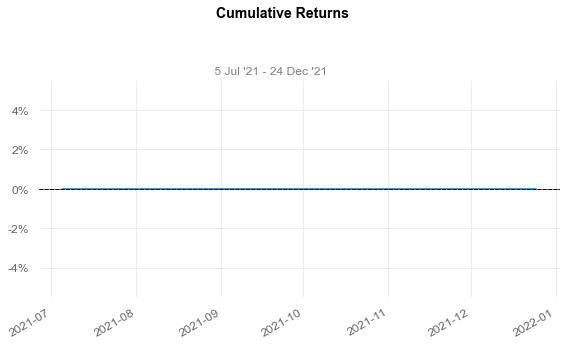

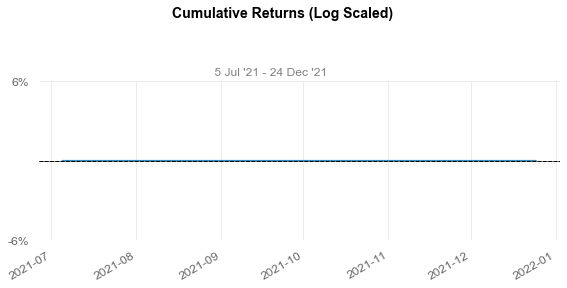

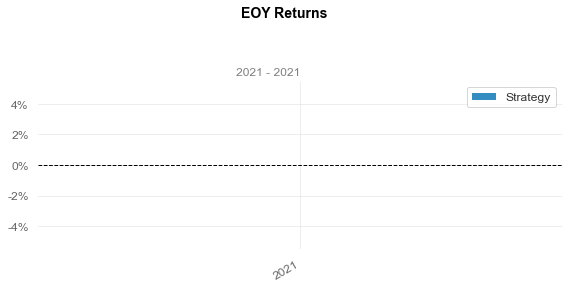

C:\Users\Usuario\.conda\envs\TFM_RL\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


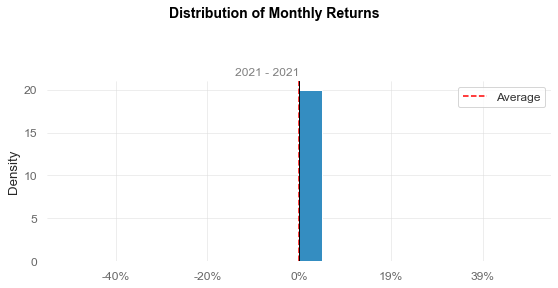

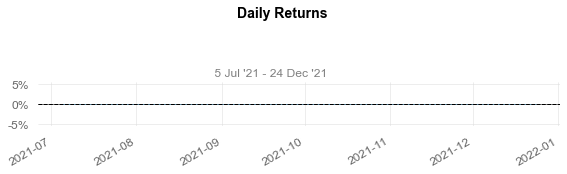

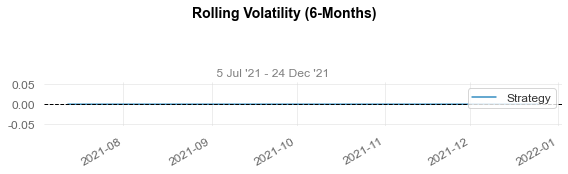

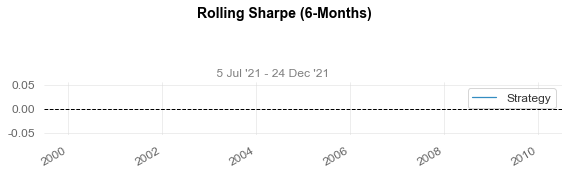

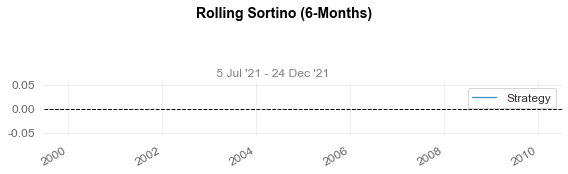

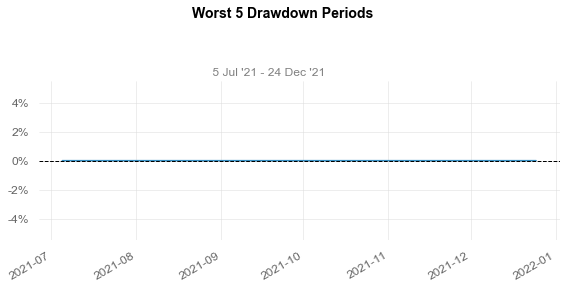

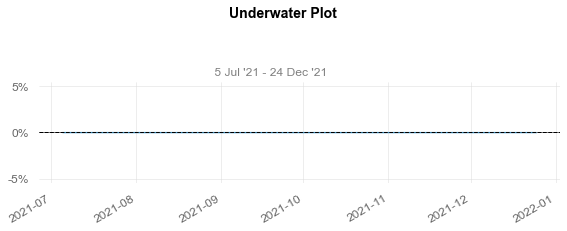

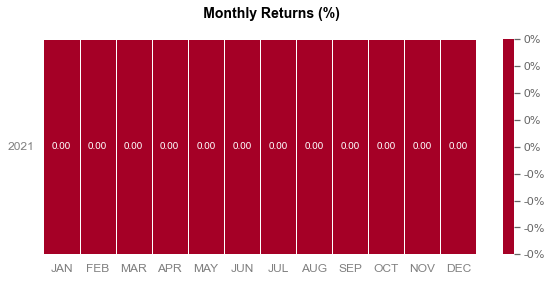

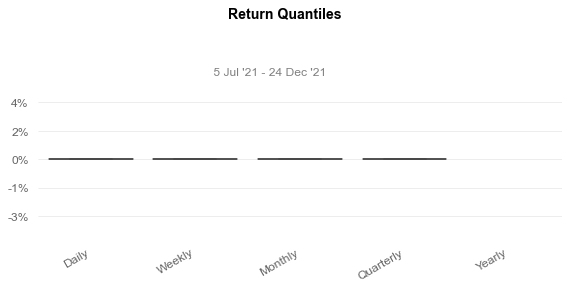

In [199]:
qs.reports.full(DQN_iter_1['GBPUSD']['DQN_LnMlpPolicy'])